In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

In [2]:
salary = pd.read_csv('resources/salary.csv')
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


1. Split your data into a training and test set. Create scatterplots, histograms, and a descriptive statistics table of the variables of interest. Do any of the variables need to be transformed to be able to use them in a linear regression model? Which variables seem like good predictors of salary?

In [3]:
#Describing the numerical features.
salary[['salary','yearsworked','yearsrank','market','exprior','yearsabs']].describe()

,salary,yearsworked,yearsrank,market,exprior,yearsabs
count,513.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,50863.220098,12.852140,7.052529,0.948521,2.926070,6.982490
std,12685.132358,9.444695,6.414771,0.149380,4.791397,16.873156
min,29000.000000,0.000000,0.000000,0.710000,0.000000,0.000000
25%,40000.000000,4.000000,2.000000,0.840000,0.000000,0.000000
50%,50096.000000,12.000000,5.000000,0.920000,0.500000,1.000000
75%,60345.000000,22.000000,12.000000,1.020000,4.000000,2.000000
max,96156.000000,41.000000,28.000000,1.330000,25.000000,118.000000


In [4]:
# getting feature correlation
correlation = salary.corr()[abs(salary.corr()["salary"]) > 0.45].sort_values(by=["salary"], ascending=False)

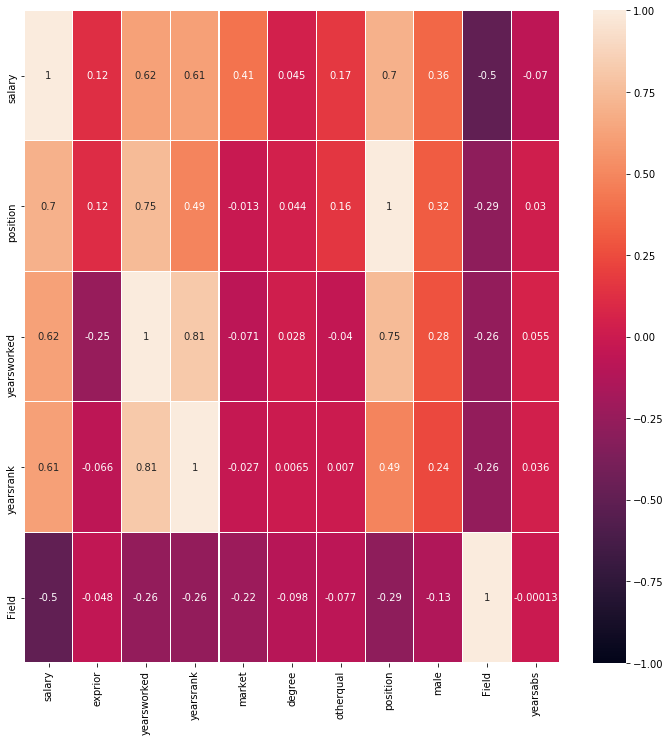

In [5]:
# correlation heatmap
plt.figure(figsize=(12,12))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, linewidth=0.1)


### Hypothesis Testing

Null Hypothesis: There is no relationship that exists between salary and all the features in the dataset.


Alternate Hypothesis: There exists a linear relationship between salary and some of the features in the dataset.

We are testing to validate if there is a relationship that exists between salary and years worked, with a significance level of 5%.

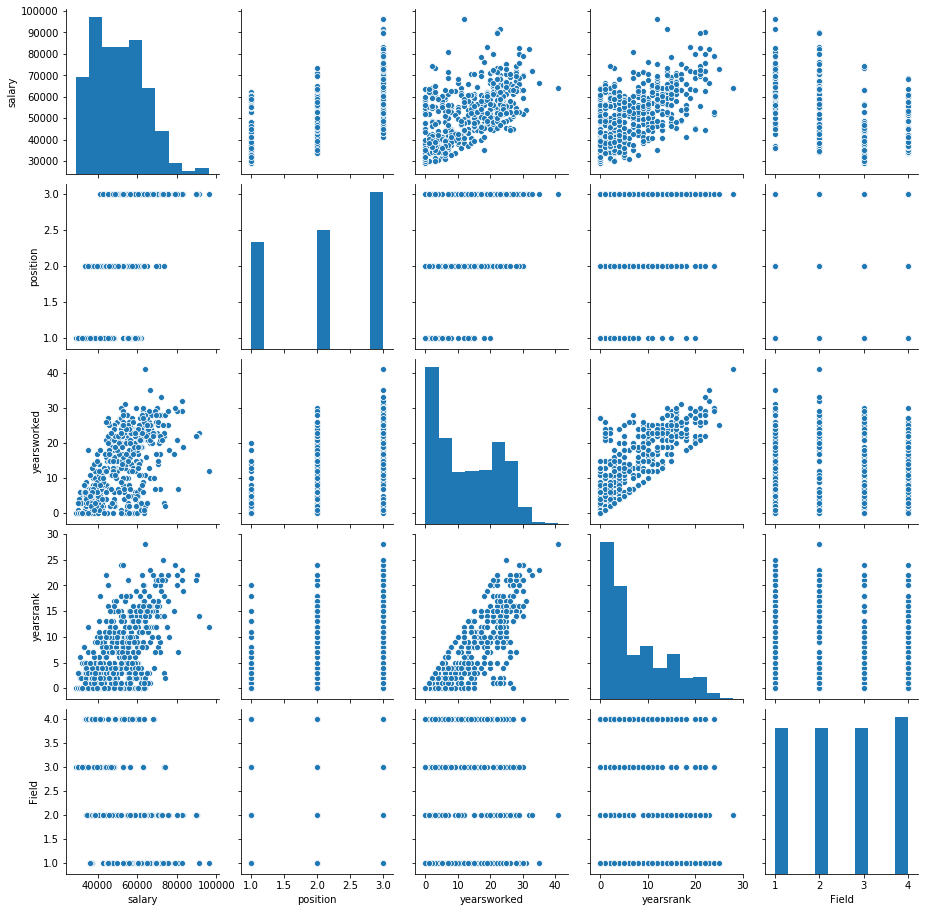

In [6]:
#Scatter and histogram
sns.pairplot(salary[['salary', 'position','yearsworked','yearsrank','Field']])

Having observed the above charts, for Years Worked and Years Rank we reject the null hypothesis reason being that there is a linear relationship between these variables. There we are selecting these variables as our predictors for the target salary.

2. One-hot encode the variable Field into three dummy variables, using HR as the reference category. You can use pandas’ get_dummies() function for this.

In [7]:
field = pd.get_dummies(salary['Field'])
field.drop(1, inplace=True, axis=1)

new_field = field.rename(columns={2:'Finance',3:'HR',4:'Marketing'})

salary= pd.concat([salary, new_field] ,axis=1, ignore_index=False)
salary.drop("Field", inplace=True, axis=1)
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,53000.0,0,0,0,1.17,1,0,1,1,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,1,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,1,2,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,1,1,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,1,1,0,0,1


#### Feature Transformation

In [8]:
total_variance = []
for i in salary.columns:
    total_variance.append(salary[i].var())

print("Overall variance: {}".format(sum(total_variance) / len(total_variance)))

Overall variance: 12377924.805858633


Due to the high total variance, features will be transformed to reduce the overall variance.

In [9]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(salary)

scaled_data = pd.DataFrame(scaled_data, columns=salary.columns)

scaled_data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,0.168612,-0.611287,-1.362104,-1.100491,1.484097,0.1905,-0.216433,-1.382068,0.575853,-0.414226,-0.569862,1.754812,-0.599824
1,0.563159,-0.402377,-1.362104,-1.100491,1.953157,0.1905,-0.216433,-1.382068,0.575853,-0.414226,1.754812,-0.569862,-0.599824
2,-0.423208,-0.611287,-1.362104,-1.100491,1.752131,0.1905,-0.216433,-1.382068,0.575853,-0.295579,-0.569862,1.754812,-0.599824
3,-1.190050,-0.611287,-1.150139,-0.944449,0.277942,0.1905,-0.216433,-1.382068,0.575853,-0.354902,-0.569862,-0.569862,1.667157
4,-1.272984,-0.611287,-1.150139,-0.788407,-0.258126,0.1905,-0.216433,-1.382068,0.575853,-0.354902,-0.569862,-0.569862,1.667157


In [10]:
scaled_variance = []
for i in scaled_data.columns:
    total_variance.append(scaled_data[i].var())

print("Overall variance: {}".format(sum(scaled_variance)))

Overall variance: 0


4. Use multiple linear regression to predict salary from all the variables in the training dataset. Interpret the standardised coefficients given in the statsmodels output. What are the most important features when predicting employee salary?

In [17]:
from statsmodels.formula.api import ols

X_train, X_test, y_train, y_test = train_test_split(
   scaled_data.drop(labels=["salary"], axis=1),
    scaled_data["salary"],
    test_size = 0.3,
    random_state = 42
)

X_train.shape, X_test.shape

((359, 12), (155, 12))

In [18]:
# X_train_yw =sm.add_constant(X_train['yearsworked'])
# X_train_yr =sm.add_constant(X_train['yearsrank'])

In [19]:
# model = ols("y_train ~ X_train_yw + X_train_yr", data=X_train).fit()
# model.summary()

In [20]:
X_train

,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
94,0.224355,-0.832191,-1.100491,-0.258126,0.190500,-0.216433,-0.161479,0.575853,-0.354902,-0.569862,1.754812,-0.599824
311,-0.611287,1.287463,1.552224,-0.392144,0.190500,4.620371,1.059111,0.575853,-0.414226,1.754812,-0.569862,-0.599824
367,-0.193466,1.711394,2.020350,0.344951,-5.249339,-0.216433,1.059111,0.575853,-0.414226,-0.569862,-0.569862,-0.599824
23,-0.611287,-1.044156,-0.632365,1.484097,0.190500,-0.216433,-1.382068,0.575853,-0.414226,-0.569862,-0.569862,-0.599824
271,-0.611287,1.075497,0.928056,-1.397272,0.190500,-0.216433,1.059111,0.575853,-0.295579,-0.569862,-0.569862,-0.599824
...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.851088,-1.044156,-0.632365,1.551105,0.190500,-0.216433,-0.161479,0.575853,-0.414226,1.754812,-0.569862,-0.599824
270,2.731284,-0.620226,-0.008197,0.277942,0.190500,4.620371,1.059111,0.575853,-0.414226,-0.569862,-0.569862,-0.599824
348,-0.193466,1.393446,-0.164239,-1.397272,0.190500,-0.216433,1.059111,0.575853,-0.354902,-0.569862,-0.569862,-0.599824
435,-0.402377,-0.832191,-0.320281,1.886148,-5.249339,4.620371,-1.382068,-1.736555,-0.354902,1.754812,-0.569862,-0.599824


In [26]:
X = sm.add_constant(X_train[['yearsworked', 'yearsrank']])
model = sm.OLS(y_train, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     136.4
Date:                Thu, 20 Feb 2020   Prob (F-statistic):           1.05e-44
Time:                        16:05:57   Log-Likelihood:                -400.78
No. Observations:                 359   AIC:                             807.6
Df Residuals:                     356   BIC:                             819.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0020      0.039     -0.051      0.959      -0.079       0.075
yearsworked     0.4045      0.065      6.253      0.000       0.277       0.532
yearsrank       0.2765      0.064      4.310      0.000       0.150       0.403
==============================================================================
Omnibus:                       36.392   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.599
Skew:                           0.807   Prob(JB):                     2.07e-10
Kurtosis:                       3.613   Cond. No.                         2.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5. Calculate the standardised residuals (resid()) and standardised predicted values (fittedvalues()).

6. Plot the residuals versus the predicted values using seaborn’s residplot with fitted values as the x parameter, and the dependent variable as y, specify lowess=True. Are there any problems with the regression?


7. Now run your model on the test set. How does your model compare when running it on the test set - what is the difference in the Root Mean Square Error (RMSE) between the training and test sets? Is there any indication that the model has been overfit or does it seem like a reasonably good model?